In [ ]:
from google.colab import drive
from tqdm import tqdm_notebook as tqdm

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/'10701-project'

/content/gdrive/MyDrive/10701-project


In [ ]:
!pip install transformers tensorboardx

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 124 kB 50.4 MB/s 
     |████████████████████████████████| 3.3 MB 39.1 MB/s 
     |████████████████████████████████| 895 kB 39.5 MB/s 
     |████████████████████████████████| 61 kB 489 kB/s 
     |████████████████████████████████| 596 kB 44.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import argparse
import logging
import os
import random
import torch.nn as nn 
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm import tqdm, trange
import csv 
from transformers import (
    AdamW,
    BertConfig,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)
from transformers import BertPreTrainedModel, BertModel

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

logger = logging.getLogger(__name__)

In [ ]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

In [ ]:
class InputExample(object):
    """
    A single training/test example for the Yelp dataset.
    For examples without an answer, the start and end position are -1.
    """
    def __init__(self,
                 stars,
                 text):
        self.stars = stars
        self.text = text

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        s = ""
        s += "stars: %d" % (self.stars)
        s += ", text: %s" % (
            self.text)
        return s

In [ ]:
class InputFeatures(object):
    """A single set of features of data."""
    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids


def read_examples_from_file(data_dir, mode):
    file_path = os.path.join(data_dir, "{}.csv".format(mode))

    examples = []
    with open(file_path, "r", encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)
        for line in reader:
            example = InputExample(
                stars=int(line[0]),
                text=line[2])
            examples.append(example)
    return examples

In [ ]:
def convert_examples_to_features(
    examples,
    label_list,
    max_seq_length,
    tokenizer,
    cls_token_at_end=False,
    cls_token="[CLS]",
    cls_token_segment_id=1,
    sep_token="[SEP]",
    sep_token_extra=False,
    pad_on_left=False,
    pad_token=0,
    pad_token_segment_id=0,
    pad_token_label_id=-100,
    sequence_a_segment_id=0,
    mask_padding_with_zero=True,
):

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            logger.info("Writing example %d of %d", ex_index, len(examples))

        tokens = []
        label_ids = []
        word = example.text
        label = example.stars
        word_tokens = tokenizer.tokenize(word)
        tokens.extend(word_tokens)
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([float(label_map[label])])

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[: (max_seq_length - special_tokens_count)]
        tokens += [sep_token]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids += [pad_token] * padding_length
            input_mask += [0 if mask_padding_with_zero else 1] * padding_length
            segment_ids += [pad_token_segment_id] * padding_length

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("tokens: %s", " ".join([str(x) for x in tokens]))
            logger.info("input_ids: %s", " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s", " ".join([str(x) for x in input_mask]))
            logger.info("segment_ids: %s", " ".join([str(x) for x in segment_ids]))
            logger.info("label_ids: %s", " ".join([str(x) for x in label_ids]))

        features.append(
            InputFeatures(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids, label_ids=label_ids)
        )
    return features

In [ ]:
class BertForSentimentAnalysis(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        # Default regression loss function
        self.loss = 'mse'

        self.init_weights()

    def set_loss(self, loss):
        self.loss = loss

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            # regression
            if self.num_labels == 1:
                if self.loss == 'mse':
                    # Use mean squared loss for regression
                    loss_fct = MSELoss()
                    loss = loss_fct(logits.view(-1), labels.view(-1))
                elif self.loss == 'smoothl1':
                    # Use smooth l1 loss for regression
                    loss_fct = torch.nn.SmoothL1Loss()
                    loss = loss_fct(logits.view(-1), labels.view(-1))
                elif self.loss == 'masked_mse':
                    # Use masked mean squared loss for regression
                    loss = masked_mse_loss(logits.view(-1), labels.view(-1))
                elif self.loss == 'masked_smoothl1':
                    # Use masked smooth l1 loss for regression
                    loss = masked_smooth_l1_loss(logits.view(-1), labels.view(-1))
                else:
                    print('Loss function not supported.')

            # classification
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)


def masked_smooth_l1_loss(input, target):
    t = torch.abs(input - target)
    smooth_l1 = torch.where(t < 1, 0.5 * t ** 2, t - 0.5)

    zeros = torch.zeros_like(smooth_l1)

    extreme_target = torch.abs(target - 2)
    extreme_input = torch.abs(input - 2)
    mask = (extreme_target == 2) * (extreme_input > 2)

    return torch.where(mask, zeros, smooth_l1).sum()


def masked_mse_loss(input, target):
    t = torch.abs(input - target)
    mse = t ** 2

    zeros = torch.zeros_like(mse)

    extreme_target = torch.abs(target - 2)
    extreme_input = torch.abs(input - 2)
    mask = (extreme_target == 2) * (extreme_input > 2)

    return torch.mean(torch.where(mask, zeros, mse))

In [ ]:
def train(args, train_dataset, model, tokenizer, labels, pad_token_label_id):
    """ Train the model """
    tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
        os.path.join(args.model_name_or_path, "scheduler.pt")
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps,
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if os.path.exists(args.model_name_or_path):
        # set global_step to gobal_step of last saved checkpoint from model path
        global_step = int(args.model_name_or_path.split("-")[-1].split("/")[0])
        epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
        steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

        logger.info("  Continuing training from checkpoint, will skip to saved global_step")
        logger.info("  Continuing training from epoch %d", epochs_trained)
        logger.info("  Continuing training from global step %d", global_step)
        logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)

    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch"
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2], "labels": batch[3]}

            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results, _ = evaluate(args, model, tokenizer, labels, pad_token_label_id, mode="val")
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    tb_writer.close()

    return global_step, tr_loss / global_step

In [ ]:
def evaluate(args, model, tokenizer, labels, pad_token_label_id, mode, prefix=""):
    eval_dataset = load_and_cache_examples(args, tokenizer, labels, pad_token_label_id, mode=mode)

    args.eval_batch_size = args.per_gpu_eval_batch_size
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    # Eval!
    logger.info("***** Running evaluation %s *****", prefix)
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None

    model.eval()
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2], "labels": batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]
            eval_loss += tmp_eval_loss
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args.regression:
        preds = np.squeeze(preds)
        for i in range(len(preds)):
            if preds[i] <= 0:
                preds[i] = 0
            elif preds[i] >= 4:
                preds[i] = 4
    else:
        preds = np.argmax(preds, axis=1)

    out_label_ids = out_label_ids.flatten()

    accuracy = accuracy_score([round(x) for x in out_label_ids], [round(x) for x in preds])
    mae = mean_absolute_error(out_label_ids, preds)
    mse = mean_squared_error(out_label_ids, preds)

    results = {
        "loss": eval_loss,
        "accuracy": accuracy,
        "mean_absolute_error": mae,
        "mean_squared_error": mse,
    }

    logger.info("***** Eval results %s *****", prefix)
    for key in sorted(results.keys()):
        logger.info("  %s = %s", key, str(results[key]))

    return results, preds

In [ ]:
def load_and_cache_examples(args, tokenizer, labels, pad_token_label_id, mode):
    # Load data features from cache or dataset file
    cached_features_file = os.path.join(
        args.data_dir,
        "cached_{}_{}_{}".format(
            mode, list(filter(None, args.model_name_or_path.split("/"))).pop(), str(args.max_seq_length)
        ),
    )

    if os.path.exists(cached_features_file) and not args.overwrite_cache:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
    else:
        logger.info("Creating features from dataset file at %s", args.data_dir)
        examples = read_examples_from_file(args.data_dir, mode)
        features = convert_examples_to_features(
            examples,
            labels,
            args.max_seq_length,
            tokenizer,
            cls_token_at_end=False,
            cls_token=tokenizer.cls_token,
            cls_token_segment_id=0,
            sep_token=tokenizer.sep_token,
            sep_token_extra=False,
            pad_on_left=False,
            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
            pad_token_segment_id=0,
            pad_token_label_id=pad_token_label_id,
        )
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if args.regression:
        all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.float)
    else:
        all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    return dataset


In [ ]:
import argparse
def get_args(data_dir, model_name_or_path=None, output_dir="./output", num_train_epochs=3.0, overwrite_output_dir=False, do_train=True):
    parser = argparse.ArgumentParser()

    # Required parameters
    parser.add_argument(
        "--data_dir",
        default=None,
        type=str,
        required=True,
        help="The input data dir. Should contain the training files for the Yelp-5 Sentiment Analysis task.",
    )
    parser.add_argument(
        "--model_name_or_path",
        default=None,
        type=str,
        required=True,
        help="Path to pre-trained model or shortcut name.",
    )
    parser.add_argument(
        "--output_dir",
        default=None,
        type=str,
        required=True,
        help="The output directory where the model predictions and checkpoints will be written.",
    )

    # Other parameters
    parser.add_argument(
        "--config_name", default="", type=str, help="Pre-trained config name or path if not the same as model_name"
    )
    parser.add_argument(
        "--tokenizer_name",
        default="",
        type=str,
        help="Pre-trained tokenizer name or path if not the same as model_name",
    )
    parser.add_argument(
        "--cache_dir",
        default="",
        type=str,
        help="Where do you want to store the pre-trained models downloaded from s3",
    )
    parser.add_argument(
        "--max_seq_length",
        default=128,
        type=int,
        help="The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--evaluate_during_training",
        action="store_true",
        help="Whether to run evaluation during training at each logging step.",
    )
    parser.add_argument(
        "--do_train",
        action="store_true",
        help="Whether to train the model or simply evaluate from output directory.",
    )
    parser.add_argument(
        "--do_lower_case", action="store_true", help="Set this flag if you are using an uncased model."
    )

    parser.add_argument("--per_gpu_train_batch_size", default=8, type=int, help="Batch size per GPU/CPU for training.")
    parser.add_argument(
        "--per_gpu_eval_batch_size", default=8, type=int, help="Batch size per GPU/CPU for evaluation."
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument("--learning_rate", default=5e-5, type=float, help="The initial learning rate for Adam.")
    parser.add_argument("--weight_decay", default=0.0, type=float, help="Weight decay if we apply some.")
    parser.add_argument("--adam_epsilon", default=1e-8, type=float, help="Epsilon for Adam optimizer.")
    parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
    parser.add_argument(
        "--num_train_epochs", default=3.0, type=float, help="Total number of training epochs to perform."
    )
    parser.add_argument(
        "--max_steps",
        default=-1,
        type=int,
        help="If > 0: set total number of training steps to perform. Override num_train_epochs.",
    )
    parser.add_argument("--warmup_steps", default=0, type=int, help="Linear warmup over warmup_steps.")

    parser.add_argument("--logging_steps", type=int, default=500, help="Log every X updates steps.")
    parser.add_argument("--save_steps", type=int, default=5000, help="Save checkpoint every X updates steps.")
    parser.add_argument(
        "--eval_all_checkpoints",
        action="store_true",
        help="Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number",
    )
    parser.add_argument("--no_cuda", action="store_true", help="Avoid using CUDA when available")
    parser.add_argument(
        "--overwrite_output_dir", action="store_true", help="Overwrite the content of the output directory"
    )
    parser.add_argument(
        "--overwrite_cache", action="store_true", help="Overwrite the cached training and evaluation sets"
    )
    parser.add_argument("--seed", type=int, default=42, help="random seed for initialization")
    parser.add_argument("--regression", action="store_true", help="Perform regression instead of classification")
    parser.add_argument(
        "--loss", default="mse", type=str, help="Use the specified loss function for regression"
    )
    args = parser.parse_args(("--data_dir %s --output_dir %s --model_name_or_path %s --num_train_epochs %d"%(data_dir, output_dir, model_name_or_path, num_train_epochs)).split())
    args.overwrite_output_dir = overwrite_output_dir
    args.do_train = do_train
    return args

In [ ]:
def main():
    args = get_args("./binary_data", output_dir="./output_binary",model_name_or_path="bert-base-uncased", num_train_epochs=3.0, overwrite_output_dir=True, do_train=True)
    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        # and args.do_train
        and not args.overwrite_output_dir
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU or CPU
    device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )

    # Set seed
    set_seed(args)
    labels = [0.0, 1.0]
    if args.regression:
        num_labels = 1
    else:
        num_labels = len(labels)
    # Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
    pad_token_label_id = CrossEntropyLoss().ignore_index

    # Load pretrained model and tokenizer
    config_class = BertConfig
    model_class = BertForSentimentAnalysis
    tokenizer_class = BertTokenizer
    config = config_class.from_pretrained(
        args.config_name if args.config_name else args.model_name_or_path,
        num_labels=num_labels,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )
    tokenizer = tokenizer_class.from_pretrained(
        args.tokenizer_name if args.tokenizer_name else args.model_name_or_path,
        do_lower_case=args.do_lower_case,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )
    model = model_class.from_pretrained(
        args.model_name_or_path,
        from_tf=bool(".ckpt" in args.model_name_or_path),
        config=config,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )

    model.set_loss(args.loss)

    model.to(args.device)

    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
      train_dataset = load_and_cache_examples(args, tokenizer, labels, pad_token_label_id, mode="train")
      global_step, tr_loss = train(args, train_dataset, model, tokenizer, labels, pad_token_label_id)
      logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
      if not os.path.exists(args.output_dir):
          os.makedirs(args.output_dir)

      logger.info("Saving model checkpoint to %s", args.output_dir)
      # Save a trained model, configuration and tokenizer using `save_pretrained()`.
      # They can then be reloaded using `from_pretrained()`
      model_to_save = (
          model.module if hasattr(model, "module") else model
      )  # Take care of distributed/parallel training
      model_to_save.save_pretrained(args.output_dir)
      tokenizer.save_pretrained(args.output_dir)

      # Good practice: save your training arguments together with the trained model
      torch.save(args, os.path.join(args.output_dir, "training_args.bin"))
    # Testing
    else:
      args.output_dir = args.model_name_or_path
    tokenizer = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=args.do_lower_case)
    model = model_class.from_pretrained(args.output_dir)
    model.to(args.device)
    result, predictions = evaluate(args, model, tokenizer, labels, pad_token_label_id, mode="test")
    # Save results
    output_test_results_file = os.path.join(args.output_dir, "test_results.txt")
    with open(output_test_results_file, "w") as writer:
        for key in sorted(result.keys()):
            writer.write("{} = {}\n".format(key, str(result[key])))
    return predictions

In [ ]:
from tqdm.notebook import tqdm_notebook as tqdm
preds = main()

In [ ]:
from sklearn.metrics import classification_report as cr
import pandas as pd

test_df = pd.read_csv("binary_dataset/test.csv")
y_true = test_df["stars"].values
report = cr(y_true, preds)
print(report)
# preds

Text(69.0, 0.5, 'True Label')

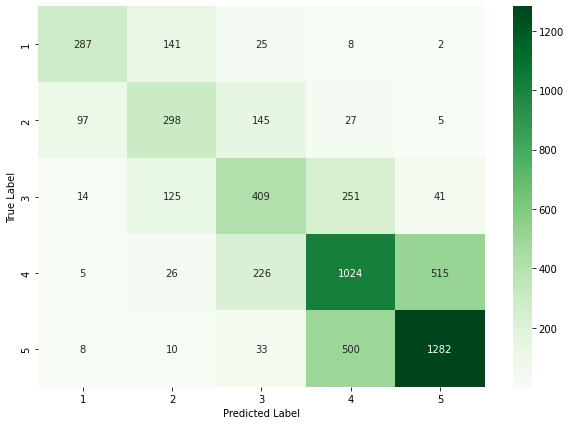

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
array = np.zeros((5,5))
for id, row in test_df.iterrows():
  array[int(row["stars"])-1][predictions[id]] += 1

df_cm = pd.DataFrame(array, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))

sn.heatmap(df_cm, annot=True, cmap="Greens", fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")